In [1]:
%matplotlib inline

import subprocess 
from PyAstronomy import pyasl
import numpy as np
import pandas as pd
import math

# -----------------------------------------------------

import ObsPlanets_Processing as OPP
import star_pop as st_pop
import MESA_processing
import hz
from star_pop import generate_star_population, plot_distributions,quantize_population
from star_pop import SamplerContainer,save_samplers,load_samplers
from MESA_processing import match_to_mesa_sims,match_to_mesa_sims_fast


# -----------------------------------------------------

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy.optimize as optimize
import numpy as np
import scipy as sp
from astropy import constants as const
from matplotlib.pyplot import cm
import matplotlib.ticker as ticker
import matplotlib.colors as colors
from pylab import rcParams
import math
import random

from scipy.stats import kde
from matplotlib.collections import PathCollection

import mesa_reader as mr
import scipy as sp
import matplotlib as mpl
import glob
import os
from pylab import rcParams
import inspect
from pathlib import Path  # Import the Path class
import dask.dataframe as dd

from astropy import constants as const

plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = 10, 10

class COLOR:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# print(COLOR.BOLD + 'Hello, World!' + COLOR.END) # ------------- example

def get_var_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

# Population

In [7]:
# --- Workflow Configuration ---
# Options: 'generate_on_the_fly', 'create_and_save_samplers', 'load_samplers_and_generate'
MODE = 'load_samplers_and_generate'  

SAVE_TO_CSV = True
SEED = random.randint(0,1e9)  # Set to None for a random run

# --- Simulation Configuration ---
NUM_STARS = 50000000
DISK_TYPE = "thin"
GALAXY_SHAPE = "spiral"    # "elliptical" or "spiral"
MZAMS_MIN, MZAMS_MAX = 50, 300
T_MAX_AGE = 13.6
FEH_MIN = -3.0
FEH_MAX = 0.5

SAMPLER_RESOLUTION = 1000000 # Controls accuracy vs. setup time for samplers


# If I save samplers the code doesn't have to sample probabilities everytime for a given random star


OUTPUT_DIR = f"{GALAXY_SHAPE}_{DISK_TYPE}_disk_run"

SAMPLER_FILE = os.path.join("samplers",f"res{SAMPLER_RESOLUTION}_{MZAMS_MIN}_{MZAMS_MAX}_samplers.pkl")
POP_DIR = os.path.join(OUTPUT_DIR,"population")

# --- Spiral Arm Configuration ---
ARM_MEMBERSHIP_PROBABILITY = [
        {'name': 'Scutum-Centaurus', 'probability': 0.30},
        {'name': 'Perseus', 'probability': 0.25},
        {'name': 'Sagittarius-Carina', 'probability': 0.20},
        {'name': 'Norma-Outer', 'probability': 0.15},
        {'name': 'Local (Orion Spur)', 'probability': 0.10}
]
# Defines the physical shape of the logarithmic spiral arms.
# a_kpc: Radius at theta=0. b: related to pitch angle. theta0_rad: rotation offset.
    # Parameters are now based on the synthesis table in Part IV of the research paper,
    # primarily derived from Reid et al. (2019) and Vallée. This provides a much more
    # observationally-grounded model of the Milky Way's current structure.
ARM_PARAMS = {
        'Scutum-Centaurus': {
            'ref_radius_kpc': 3.14,
            'ref_angle_deg': 25,
            'pitch_angle_deg': 12.0,
            'radial_range_kpc': [3.0, 16.0]
        },
        'Sagittarius-Carina': {
            'ref_radius_kpc': 4.93,
            'ref_angle_deg': -45,
            'pitch_angle_deg': 13.1,
            'radial_range_kpc': [4.0, 16.0]
        },
        'Perseus': {
            'ref_radius_kpc': 9.94,
            'ref_angle_deg': 150,
            'pitch_angle_deg': 9.5,
            'radial_range_kpc': [6.0, 18.0]
        },
        'Norma-Outer': {
            'ref_radius_kpc': 4.00,
            'ref_angle_deg': -100,
            'pitch_angle_deg': 13.0,
            'radial_range_kpc': [3.5, 20.0]
        },
        'Local (Orion Spur)': {
            'ref_radius_kpc': 8.15,
            'ref_angle_deg': 0, # Sun is reference for Local arm
            'pitch_angle_deg': 10.1,
            'radial_range_kpc': [6.0, 9.0]
        }
}

In [3]:
# --- Seed the random number generators for reproducibility ---
if SEED is not None:
    np.random.seed(SEED)
    random.seed(SEED)

# --- Main Workflow Logic ---
samplers = None
if MODE == 'create_and_save_samplers':
    samplers = SamplerContainer(MZAMS_MIN, MZAMS_MAX, resolution=SAMPLER_RESOLUTION)
    save_samplers(samplers, SAMPLER_FILE)

else: # For 'generate_on_the_fly' or 'load_samplers_and_generate'
    if MODE == 'load_samplers_and_generate':
        if not os.path.exists(SAMPLER_FILE):
            raise FileNotFoundError(f"Sampler file not found: {SAMPLER_FILE}. Please run in 'create_and_save_samplers' mode first.")
        samplers = load_samplers(SAMPLER_FILE)
    else: # generate_on_the_fly
        samplers = SamplerContainer(DISK_TYPE, MZAMS_MIN, MZAMS_MAX, resolution=SAMPLER_RESOLUTION)


Samplers loaded from samplers/res1000000_50_300_samplers.pkl


Generating 50000000 stars for the 'thin' disk model...
Generation complete.
Original data saved to spiral_thin_disk_run/population/star_population_thin_50000000.csv

Here are the first 5 stars from the simulation:
        Mzams  Age [Gyr]      Fe/H  Radial Distance [kpc]  \
0   98.190764   2.103312 -0.220575               3.890950   
1  158.005508   5.588669 -0.322854               4.619964   
2  217.106380   6.081922 -0.347689               6.640248   
3   66.895852   7.791229 -0.467090               4.781109   
4   59.309891   1.157641 -0.108463               7.578349   

   Vertical Distance [kpc]      Arm Position  alpha_angle_deg population_type  \
0                 3.119878  Scutum-Centaurus       103.398921       thin_disk   
1                 0.013593           Perseus       -85.075799       thin_disk   
2                 0.599291  Scutum-Centaurus       194.843659       thin_disk   
3                 0.095219  Scutum-Centaurus       120.051508       thin_disk   
4             

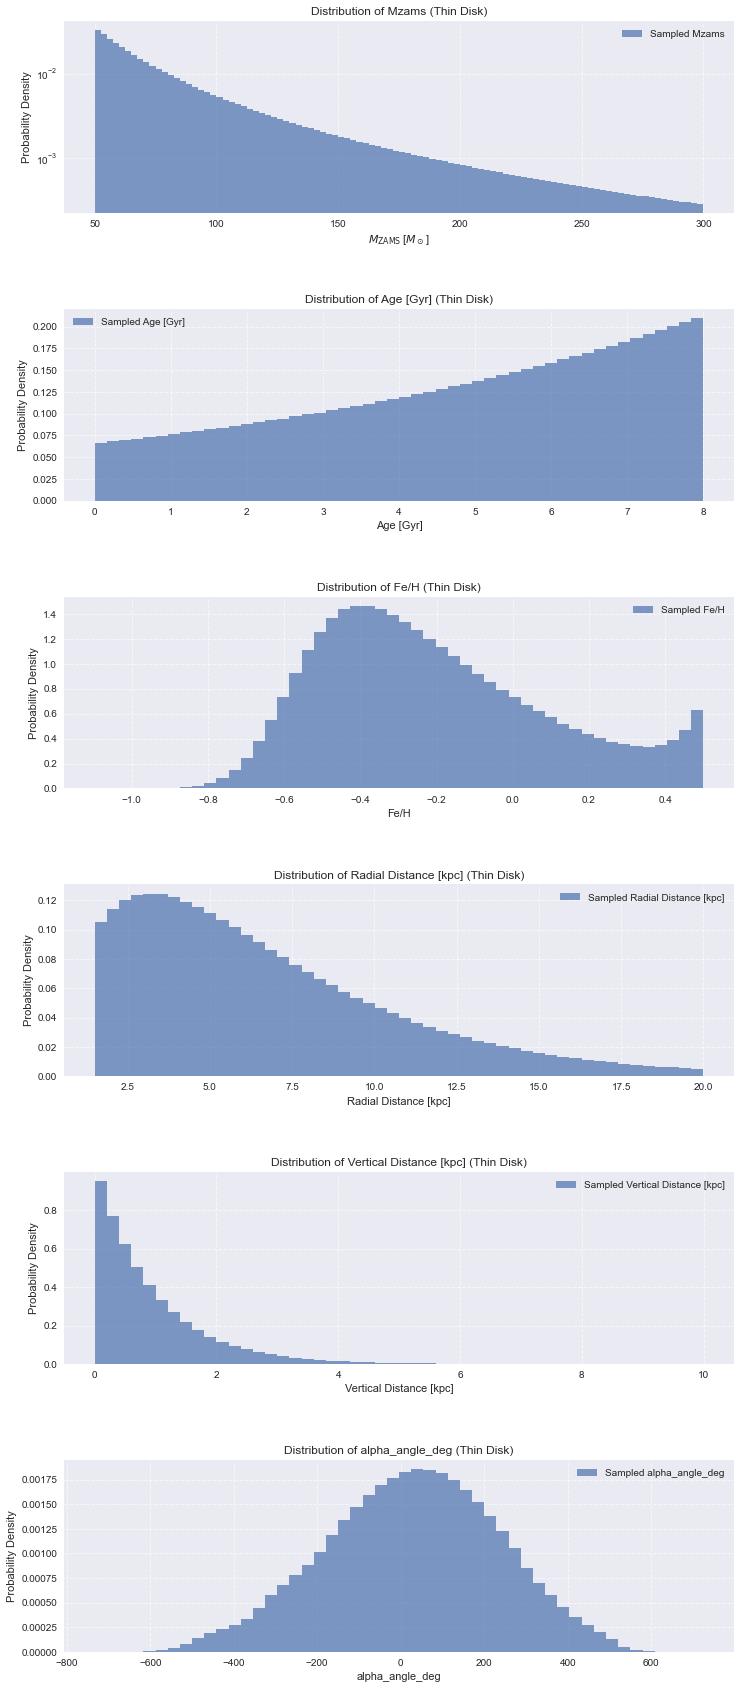

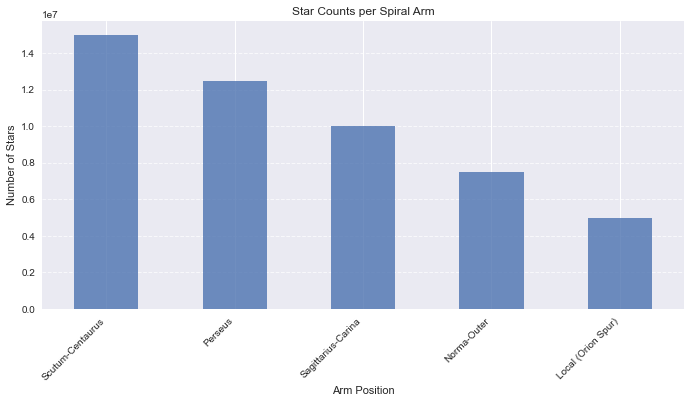

In [4]:
# 1. Generate the stellar population
population_df = generate_star_population(
    num_stars=NUM_STARS,
    samplers=samplers,
    disk_type=DISK_TYPE,
    galaxy_shape=GALAXY_SHAPE,
    arm_params_list=ARM_PARAMS,
    arm_membership_prob=ARM_MEMBERSHIP_PROBABILITY,
    seed=SEED,
    FeH_min=FEH_MIN,  # Pass the new limits
    FeH_max=FEH_MAX   # Pass the new limits
    )

# 2. Optionally save the original data
if SAVE_TO_CSV:
    if not os.path.exists(POP_DIR):
        os.makedirs(POP_DIR)
    filepath = os.path.join(POP_DIR, f"star_population_{DISK_TYPE}_{NUM_STARS}.csv")
    population_df.to_csv(filepath, index=False)
    print(f"Original data saved to {filepath}")

# You can now work with the data directly! For example:
print("\nHere are the first 5 stars from the simulation:")
print(population_df.head())

print("\nHere are some basic statistics about the population:")
print(population_df.describe())


# 3. Call the plotting function to visualize the results
plot_distributions(population_df, disk_type=DISK_TYPE)

## Take the datafile

In [3]:
population_df = pd.read_csv(f"{OUTPUT_DIR}/population/star_population_{DISK_TYPE}_{NUM_STARS}.csv",
                            low_memory=False)

# 2. Identify and remove rows where column 'A' is not numeric
# Create a mask to KEEP rows that are convertible to numbers
numeric_mask = pd.to_numeric(population_df['Mzams'], errors='coerce').notna()

# Filter the DataFrame and create a clean copy
if len(numeric_mask[numeric_mask==False])>=1:
    population_df = population_df[numeric_mask]
    print(f"{len(numeric_mask[numeric_mask==False])} rows removed.")
    
    population_df.to_csv(f"{OUTPUT_DIR}/star_population_{DISK_TYPE}_{NUM_STARS}.csv", index=False)

## Quantization

Quantizing mass and metallicity using vectorized NumPy...
Quantization complete.


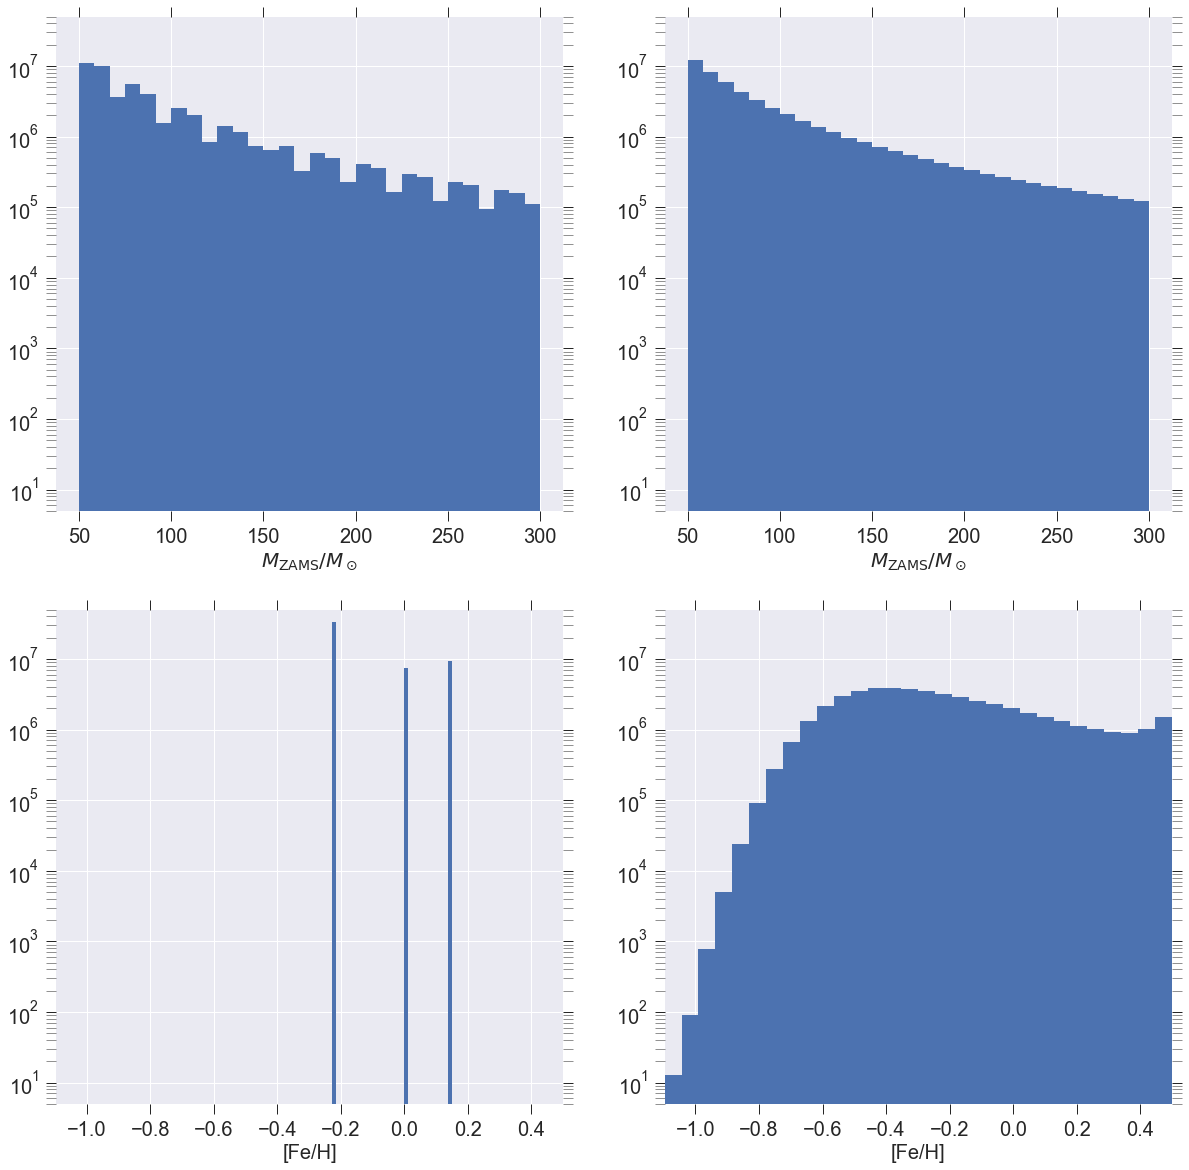

In [4]:
# This grid defines the available stellar masses for the model.
# The quantization function will snap generated masses to the nearest value in this list.
# For some reason MESA didn't manage to relax a 105 Msun star to be used in simulations.
#   I took this data point out
stellar_mass_grid = np.delete(np.arange(50, 305, 5), 20)

# This grid defines the available metallicities ([Fe/H]) for the model.
# By setting this metallicity bins I am effectively binning every star within 20% from Zsun into Zsun.
#    Since I only give the 1Zsun folder, the model will only take that and ignore the other bins
metallicity_grid = np.log10([0.6,1,1.4])/0.977     # Bertelli et al. 1994a

q_df = quantize_population(population_df, stellar_mass_grid, metallicity_grid,in_place=False)

# 1. Construct the full file path
filepath_q = os.path.join(OUTPUT_DIR, "quantized", f"star_population_{DISK_TYPE}_{NUM_STARS}_q.csv")

# 2. Get the directory part of the path
output_directory = os.path.dirname(filepath_q)

# 3. Create the directory if it doesn't exist
Path(output_directory).mkdir(parents=True, exist_ok=True)

# 4. Now, save the file with confidence
q_df.to_csv(filepath_q, index=False) 


# 5. Plot

plt.style.use('seaborn-v0_8')

fig, ax = plt.subplots(2,2,figsize=(20,20))

ax[0,0].hist(q_df["Mzams"],bins=30)
ax[0,1].hist(population_df["Mzams"],bins=30)

ax[1,0].hist(q_df["Fe/H"],bins=30)
ax[1,1].hist(population_df["Fe/H"],bins=30)

for axs in ax:
    for xs in axs:
        xs.set_yscale('log')
        xs.tick_params(labelsize=20,axis='both', which='both',top=True,right=True,length=10)
        if xs == ax[0,0] or xs == ax [0,1]:
            xs.set_ylim(5,len(q_df["Mzams"]))
            xs.set_xlabel("$M_\mathrm{ZAMS}/M_\odot$",fontsize=20)
        else:
            xs.set_ylim(5,len(q_df["Fe/H"]))
            xs.set_xlim(np.min([np.min(q_df["Fe/H"]),np.min(population_df["Fe/H"])]),
                        np.max([np.max(q_df["Fe/H"]),np.max(population_df["Fe/H"])]))
            xs.set_xlabel("[Fe/H]",fontsize=20)
    

plt.show()

### Combine with MESA tracks

In [8]:
base_path = "/sample/"
mesa_cols_to_extract = ["star_age","star_mass","log_R","log_Teff","log_L","log_Rzams","log_Lzams",
                        "log_Teffzams","log_RMAX","RMAX_logL","RMAX_logTeff","max_age"]

WR_cond = 'gamma_eta'      # !!!!remember to change it your thick winds transition!!!!


# Either extract from pre-existing parquet outputs or do the long calculation
what_to_do = 'just_extract'        
output_dir = "./mesa_matched_chunks"

if NUM_STARS < 1e7 and what_to_do == 'just_extract':
    df_mesa = dd.read_parquet('./mesa_matched_chunks/matched_chunk.parquet')
    print(f"Dataset has {len(df_mesa)} rows and {len(df_mesa.columns)} columns.")

elif what_to_do == 'just_extract':
    df_mesa = dd.read_parquet('./mesa_matched_chunks/*.parquet')
    print(f"Dataset has {len(df_mesa)} rows and {len(df_mesa.columns)} columns.")
    
elif NUM_STARS < 1e7 and what_to_do == 'generate':
    df_mesa = match_to_mesa_sims_fast(q_df, base_path, mesa_cols_to_extract,WR_cond=WR_cond)
    
    if matched_chunk_df is not None and not matched_chunk_df.empty:
    # Use Parquet format: it's fast, efficient, and preserves data types
        output_path = os.path.join(output_dir, "matched_chunk.parquet")
        df_mesa.to_parquet(output_path)
        print(f"Chunk {i+1} successfully processed and saved to {output_path}")
    
elif what_to_do == 'generate':
#     We need something more sophsticated to deal with RAM overfilling
    # 1. Define chunk size and output directory
    chunk_size = 10_000_000  # 10 million rows per chunk (adjust based on your RAM)
    num_chunks = int(np.ceil(len(q_df) / chunk_size))
    os.makedirs(output_dir, exist_ok=True)

    print(f"Processing {len(q_df)} stars in {num_chunks} chunks of size {chunk_size}...")

    # 2. Loop through the DataFrame in chunks
    for i in range(num_chunks):
        start_index = i * chunk_size
        end_index = (i + 1) * chunk_size
    
        # Get the chunk
        df_chunk = q_df.iloc[start_index:end_index]
    
        print(f"\n--- Processing Chunk {i+1}/{num_chunks} ---")
    
    # 3. Run the function on the smaller chunk
    # The function will now work because the memory usage is contained
        matched_chunk_df = match_to_mesa_sims_fast(df_chunk, base_path, mesa_cols_to_extract,WR_cond=WR_cond)
    
    # 4. Save the result to a file instead of keeping it in memory
        if matched_chunk_df is not None and not matched_chunk_df.empty:
            # Use Parquet format: it's fast, efficient, and preserves data types
            output_path = os.path.join(output_dir, f"matched_chunk_{i+1}.parquet")
            matched_chunk_df.to_parquet(output_path)
            print(f"Chunk {i+1} successfully processed and saved to {output_path}")

    print("\nAll chunks processed!")
    
    df_mesa = dd.read_parquet('./mesa_matched_chunks/*.parquet')

    print(f"Dataset has {len(df_mesa)} rows and {len(df_mesa.columns)} columns.")

Dataset has 2217 rows and 29 columns.


## Plot HRD

In [9]:
Rsun =6.9599e+10                                 # cm
Lsun =3.826e+33                                  # [egr s-1]
Tsun = 5778                                      # Solar effective temperature in K
sigma=5.6724e-05*Rsun*Rsun/Lsun                  # Stefan constant [L_sun R_sun^{-2} K^{-4}] 

def lumHR(R,logT):
    
    L = np.log10(4*np.pi*R**2*spc.sigma*(10**logT)**4)
    
    return L

def lum_Lsun(R,logT):
    
    L = np.log10(R**2*((10**logT)/5778)**4)
    
    return L

def Teff(R,logL):
    
    T = np.log10(((10**logL/R**2)**(1/4))*5778)
    
    return T

def load_mesa_models(folder_names, direc , mix_reg = True, num_mix_reg = 31):
    """
    Loads MESA history.data files into a list of MesaData objects.

    Args:
        folder_names (list): A list of strings, where each string is a folder name
                             containing MESA LOGS.

    Returns:
        list: A list of mesa_reader.MesaData objects, ordered according to folder_names.
    """
    directories = []
    files_list = []

    for folder_name in folder_names:
        directories.append(f"{direc}/{folder_name}")
        files_list.append(glob.glob(f"{directories[-1]}/LOGS/*.data"))

    file_str = 'history'
    data_files = []

    for j, files_in_dir in enumerate(files_list):
        found_file = False
        for x in files_in_dir:
            if file_str in x:
                if not found_file:
                    print(f'{folder_names[j]} ----- File used: \n{x}\n')
                    data_files.append(x)
                    found_file = True
                else:
                    raise ValueError(f'There is more than one file name containing the string "{file_str}" in {folder_names[j]}. Please be more specific!')
        if not found_file:
            print(f"Warning: No '{file_str}.data' file found in {folder_names[j]}/LOGS/. Skipping this folder.")
            data_files.append(None) # Append None or handle this case as appropriate

    mesa_models = []
    RMAX = []
    massCC = []
    
    print("\n----------------------------------------------------------\n\n")
    
    for i, data_file_path in enumerate(data_files):
        if data_file_path is None:
            # Handle cases where no data file was found for a folder
            mesa_models.append(None) # Append None to maintain list alignment
            RMAX.append(None)
            massCC.append(None)
            continue

        print(i, data_file_path)

        # Directly append the MesaData object to the list
        m = mr.MesaData(data_file_path)
        mesa_models.append(m)

        RMAX.append(np.max(10**m.log_R))
        Mcore = np.max([m.he_core_mass[-1], m.co_core_mass[-1], m.one_core_mass[-1]])
        massCC.append([Mcore, m.star_mass[-1] - Mcore])

        # Mixing regions list
        if mix_reg:
            mx_type = []
            mx_qtop = []
            for j in range(1, num_mix_reg + 1): # Iterate up to num_mix_reg
                try:
                    mx_type.append(getattr(m, f"mix_type_{j}"))
                    mx_qtop.append(getattr(m, f"mix_qtop_{j}"))
                except AttributeError:
                    # Handle cases where a mix_type_j might not exist for all models
                    # print(f"Warning: mix_type_{j} or mix_qtop_{j} not found in model {folder_names[i]}.")
                    pass # Or break if you expect all to have 30 mixing regions

            # Assign these lists directly to the model object if needed later,
            # or return them if they are part of the function's output.
            # For now, I'll keep them local as they are not explicitly returned in your original snippet
            # You might want to add them as attributes to 'm' if you use them outside this function.
            # For example:
            m.mx_type_list = np.array(mx_type)
            m.mx_qtop_list = np.array(mx_qtop)


        # Assuming .read_data() is necessary for some MESA versions or data types
        # It's better to call this if MesaData objects don't load all data by default
        # or if it's explicitly required.
        # If mesa_reader.MesaData(path) already loads everything, this might be redundant.
        # m.read_data() # Uncomment if needed based on your mesa_reader version

    # massCC is already appended as a list of lists, then converted to array and transposed
    massCC = np.array(massCC).transpose()
    
    print("\n ----------------------- DONE ------------------------\n")
    
    return mesa_models, RMAX, massCC #



def plot_stellar_data(ax, data_sources, panel_title, panel_title_color='red'):
    """
    This function now ONLY plots the stellar data points and sets the title/legend.
    """
    
    temp = np.arange(10**3.2,10**6,100)
    HR_thresh= temp**2*np.sqrt(4*np.pi*sigma)*(10**5)
    ind_LBV=[]
    for i in range(len(HR_thresh)):
        if HR_thresh[i]<10**5.5:
            ind_LBV.append(i)
    for j in ind_LBV:
        HR_thresh[j]=10**5.5
    ax.fill_between(np.log10(temp), np.log10(HR_thresh), 9.5, color='cyan',hatch='O',facecolor='white',alpha=0.2, 
                 zorder=1)
    
    if panel_title in ['MSc',r"MSc$_\mathrm{V01}$",r"FESc$_\mathrm{V01}$","Dutch"]:
        ax.axvline(x=np.log10(27000),ls=':',lw=3,c='m')
        

    for df, label, color, marker in data_sources:
        if len(df.index) != 0:
            ax.scatter(
                df["log_Teff"],
                df["log_L"],
                color=color,
                marker=marker,
                label=label,
                edgecolors=(0, 0, 0, 0.2),
                lw=0.5,
                s=80,
                zorder=1
            )
    ax.text(0.95, 0.95, panel_title, transform=ax.transAxes, fontsize=25,
            color=panel_title_color, ha='right', va='top', weight='bold')
    ax.legend(loc='lower right', title="Stellar Type", fontsize=18, title_fontsize=20)

# --- NEW Function to draw lines and labels ---
def draw_iso_radius_lines_and_labels(ax):
    """
    This function is now separate. It is called AFTER final axis limits are set.
    """
    # --- Plot Iso-Radius Lines ---
    radii_to_plot = [1, 10, 100, 1000]
    TEFF_range = np.linspace(3.5, 5.5, 100)

    for R in radii_to_plot:
        L_vals = [lum_Lsun(R, T) for T in TEFF_range]
        ax.plot(TEFF_range, L_vals, '--', color='gray', lw=1.5, zorder=1)

    # --- DYNAMICALLY PLACE AND ROTATE RADIUS LABELS ---
    # This logic now runs on the final, correct axis limits.
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    position_factor = 0.7

    for R in radii_to_plot:
        intersections = []
        for x in xlims:
            y = lum_Lsun(R, x)
            if ylims[0] <= y <= ylims[1]:
                intersections.append((x, y))
        for y in ylims:
            x = Teff(R, y)
            if xlims[1] <= x <= xlims[0]:
                is_duplicate = any(np.isclose(ix, x) and np.isclose(iy, y) for ix, iy in intersections)
                if not is_duplicate:
                    intersections.append((x, y))

        if len(intersections) >= 2:
            intersections.sort(key=lambda p: p[0])
            p1, p2 = intersections[0], intersections[-1]
            label_logT = p1[0] + position_factor * (p2[0] - p1[0])
            label_logL = p1[1] + position_factor * (p2[1] - p1[1])
            
            p1_display = ax.transData.transform(p1)
            p2_display = ax.transData.transform(p2)
            angle = np.degrees(np.arctan2(p2_display[1] - p1_display[1], p2_display[0] - p1_display[0]))
            
            if 90 < angle <= 180 or -180 < angle < -90:
                 angle += 180

            label_text = f'{R} R$_\\odot$'
            ax.text(label_logT, label_logL, label_text, ha='center', va='center',
                    rotation=angle, rotation_mode='anchor', color='dimgray', fontsize=16,
                    bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.1'))
    
# --- Plotting Setup ---
layout_WR = {
    "WR": ['r','d'],
    "OB-type": ['lightblue','v'],
    "YSG":["#f7d560", "o"],
    "naked_He": ["pink","h"]
}
            
# ------------ Upload Observations ---------------------------

df_OB = pd.read_excel('/Observations/OB_stars_cat.ods', engine='odf')
df_OB_M08 = pd.read_excel('/Observations/OB_stars_cat_M08.ods', engine='odf')
df_WR_P25 = pd.read_excel('/Observations/WR_stars_cat_P25.ods', 
                          engine='odf')
df_WN_GM25 = pd.read_excel('/Observations/WN_stars_cat_GM25.ods',
                           engine='odf')

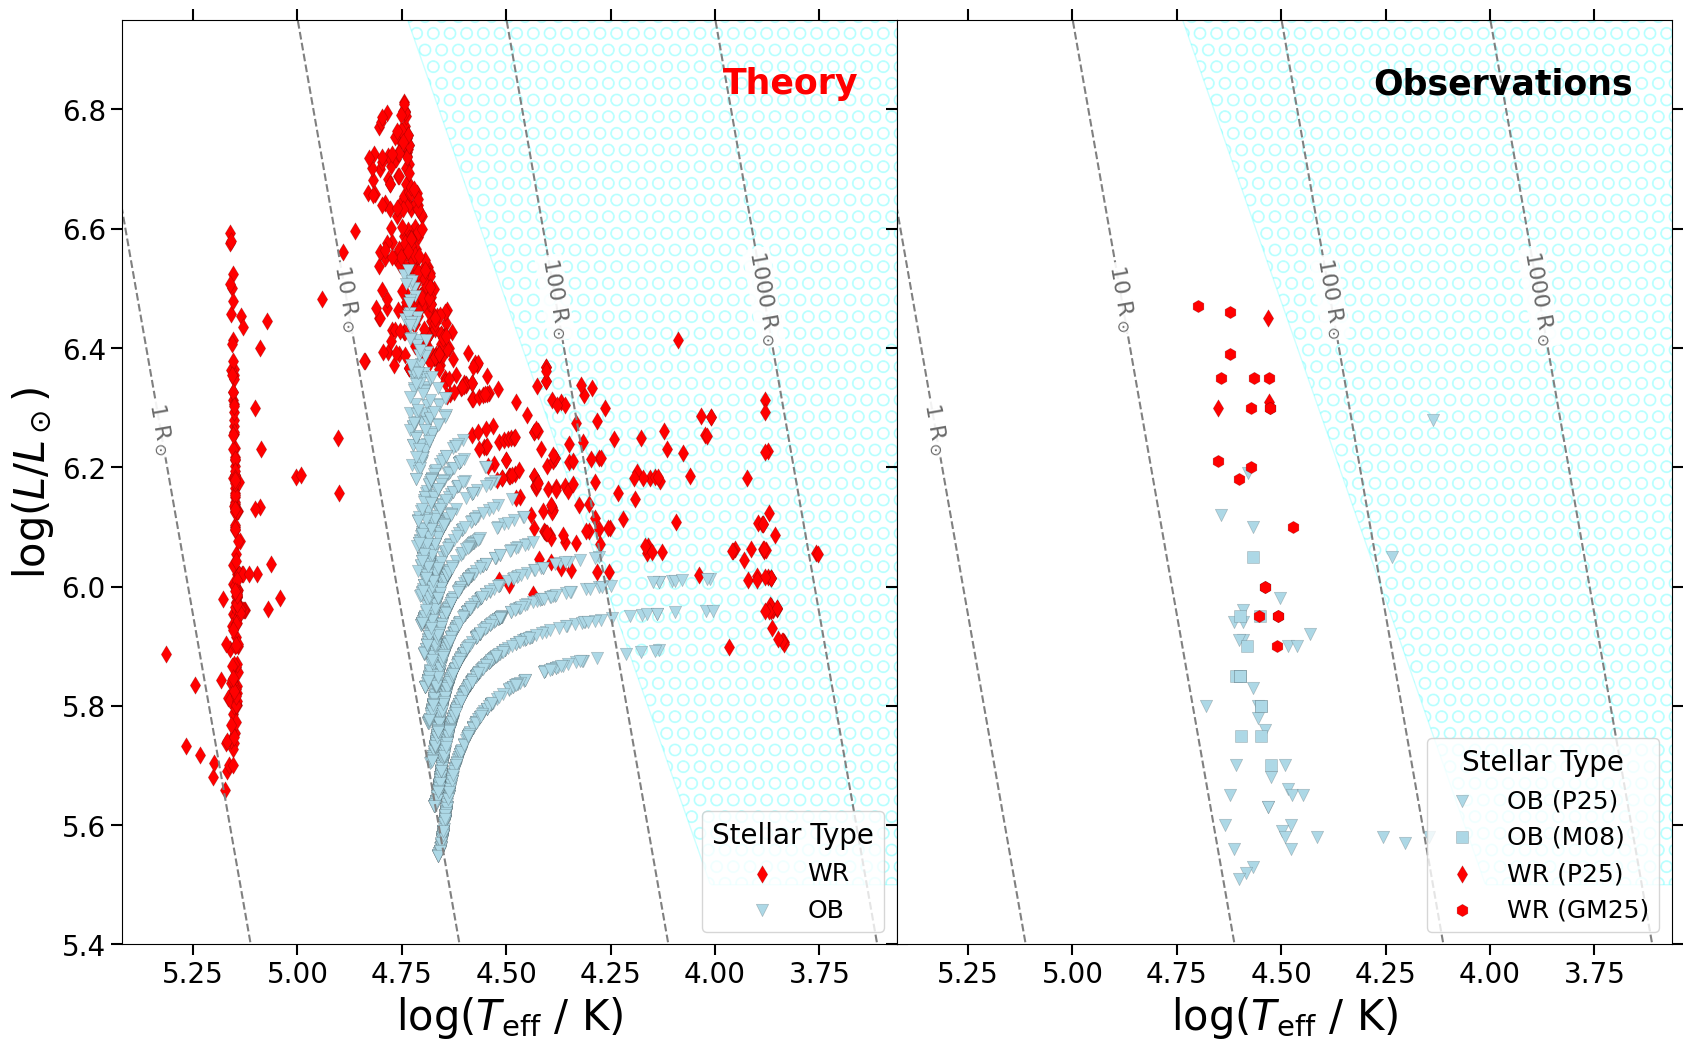

In [13]:
# --- Figure Setup ---
# This is just for a two side-by-side plots. You can freely expand in case of need

plt.style.use('default')


fig, axes = plt.subplots(1, 2, figsize=(20, 12), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0,hspace=0)

# --- Prepare Observational Data ---
observational_dfs = [df_OB, df_OB_M08, df_WR_P25, df_WN_GM25]

# This part is just that I am too lazy to change the rest of the code
for df in observational_dfs:
    if 'Teff' in df.columns and 'log_Teff' not in df.columns:
        df['log_Teff'] = np.log10(df['Teff'])
    if 'logL' in df.columns and 'log_L' not in df.columns:
        df['log_L'] = df['logL']
    df.drop(df[df['log_L'] < 5.5].index, inplace=True)

# --- Define Data Layouts for Each Panel ---
layout = [
    (df_mesa[df_mesa['stellar_type'] == 'WR'], 'WR', 'r', 'd'),
    (df_mesa[df_mesa['stellar_type'] == 'OB-type'], 'OB', 'lightblue', 'v'),
    (df_mesa[df_mesa['stellar_type'] == 'YSG'], 'YSG', '#f7d560', 'o')
]

layout_Obs = [
    (df_OB, 'OB (P25)', 'lightblue', 'v'),
    (df_OB_M08, 'OB (M08)', 'lightblue', 's'),
    (df_WR_P25, 'WR (P25)', 'r', 'd'),
    (df_WN_GM25, 'WR (GM25)', 'r', 'h')
]

plot_stellar_data(axes[0], layout, 'Theory', 'red')
plot_stellar_data(axes[1], layout_Obs, 'Observations', 'black')


# --- Determine Global Axis Limits from ALL data ---
all_Teff = []
all_L = []
for df, _, _, _ in layout + layout_Obs:
    all_Teff.extend(df['log_Teff'])
    all_L.extend(df['log_L'])

global_xlim = (np.min(all_Teff) * 0.95, np.max(all_Teff) * 1.02)
global_ylim = (np.min(all_L) * 0.98, np.max(all_L) * 1.02)

# --- Final Formatting for the Entire Figure ---
# NOW we apply limits and draw the lines/labels
for axss in axes:
    axss.set_ylim(global_ylim)
    axss.set_xlim(global_xlim)
    axss.invert_xaxis()
    
    # Draw lines and labels on the finalized axes
    draw_iso_radius_lines_and_labels(axss)
    
    axss.tick_params(axis='both', which='major', labelsize=20, top=True, right=True, length=8, width=1.5)
    axss.tick_params(axis='both', which='minor', top=True, right=True, length=4, width=1)
    axss.set_xlabel('log($T_\\mathrm{eff}$ / K)', fontsize=30)

# Set labels only on the outer plots
axes[0].set_ylabel('log($L/L_\\odot$)', fontsize=30)

plt.show()